In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#LHCb. DataPreprocessor.
This class prepare LHCb data for other classes which are use used data in special form.

LHCb data is shown below:

In [2]:
lhcb_data = pd.read_excel('Data/popularity-728days.xls')
lhcb_data.irow(range(0,3))

,Name,Configuration,ProcessingPass,FileType,Type,Creation-week,NbLFN,LFNSize,NbDisk,DiskSize,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08-MINBIAS-FIRST-14-NB/Stripping12d,MINIBIAS.DST,1,104591,67,0.317900,134,0.635799,...,12687,12687,12687,12687,12687,12687,12687,12687,12687,12687
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,BHADRON.DST,1,104607,227,0.649204,980,2.819260,...,1631,1631,1631,1631,1631,1631,1631,1631,1631,1631
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,CALIBRATION.DST,1,104607,355,1.370105,355,1.370105,...,0,0,0,474,708,708,708,708,708,708


LHCb data preparation and data form are shown below.

In [3]:
from datapop.LHCb import DataPreprocessor
data = DataPreprocessor(data=lhcb_data).get_preprocessed_data()
data.irow(range(0,3))

,ID,1,2,3,4,5,6,7,8,9,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,134
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,234,474,0,0,...,0,0,0,0,0,0,0,0,0,0


#Core. ProbabilityEstimator.

This class is used to estimate dataset probabilities on given type of data storage. 
Higher a dataset's probability for a storage type, more suitable this storage type for the dataset in future.

The class accept the data form shown above.

In [4]:
from datapop.core import ProbabilityEstimator
probability_estimator = ProbabilityEstimator(data=data, forecast_horizont=26, class_abs_thresholds=1)
probability_report = probability_estimator.get_probabilities()
probability_report.irow(range(0,3))

KFold prediction using folds column


,ID,Current_Type,Proba_Type_0,Proba_Type_1
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1,0.000023,0.999977
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1,0.938475,0.061525
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0.989872,0.010128


Also it is possible to get data that was used for the estimator training.

In [5]:
probability_estimator.preprocessed_data.irow(range(0,3))

,ID,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,FirstUsage,Type
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,0,...,66,0,198,728,1562,864,264,333,95,1
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,89,1
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0,0,0,0,234,474,0,0,...,0,0,0,0,0,0,0,0,99,0


Furthermore, the class gives trained classifier which was used for probabilities estimation.

In [6]:
classifier = probability_estimator.classifier

Some usefull metrics and pictures can be done by using probability_report

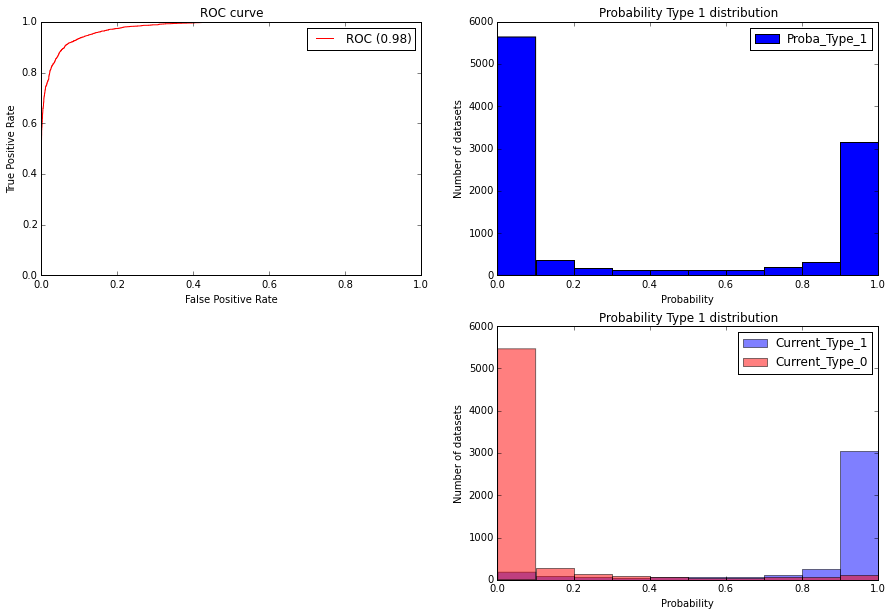

In [7]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(15, 10))

plt.subplot(2,2,1)
fpr, tpr, _ = roc_curve(probability_report['Current_Type'].values, probability_report['Proba_Type_1'].values)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC (%.2f)' % roc_auc, c='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')

plt.subplot(2,2,2)
plt.hist(probability_report['Proba_Type_1'].values, color='b', label='Proba_Type_1')
plt.title('Probability Type 1 distribution')
plt.xlabel('Probability')
plt.ylabel('Number of datasets')
plt.legend(loc='best')

plt.subplot(2,2,4)
cur_type = probability_report['Current_Type']
plt.hist(probability_report['Proba_Type_1'][cur_type==1].values, alpha=0.5, color='b', label='Current_Type_1', bins=10)
plt.hist(probability_report['Proba_Type_1'][cur_type==0].values, alpha=0.5, color='r', label='Current_Type_0', bins=10)
plt.title('Probability Type 1 distribution')
plt.xlabel('Probability')
plt.ylabel('Number of datasets')
plt.legend(loc='best')

###Test on future time series values
Train on 1-(104-2*forecast_horizont) weeks, test on (forecast_horizont)-(104-forecast_horizont) weeks.

In [4]:
from datapop.core import ProbabilityEstimator
estimator = ProbabilityEstimator(data=data, forecast_horizont=26, class_abs_thresholds=1)
auc_train, auc_test = estimator._test_future_proba()
print auc_train, auc_test

KFold prediction using folds column
KFold prediction using folds column
0.992022343018 0.917083679202


KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column
KFold prediction using folds column


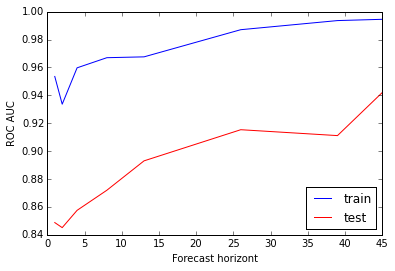

In [5]:
horizonts = [1,2,4,8,13,26,39,45]
aucs_train = []
aucs_test = []
X = []
for horizont in horizonts:
    estimator = ProbabilityEstimator(data=data, forecast_horizont=horizont, class_abs_thresholds=1)
    auc_train, auc_test = estimator._test_future_proba()
    aucs_train.append(auc_train)
    aucs_test.append(auc_test)
    X.append(horizont)
plt.plot(X, aucs_train, color='b', label='train')
plt.plot(X, aucs_test, color='r', label='test')
plt.xlabel('Forecast horizont')
plt.ylabel('ROC AUC')
plt.legend(loc='best')
plt.show()


#Core. ForecastNumberAccesses.

This class is used to predict future number of accesses to datasets.

Prediction of number of accesses to datasets for 105th week and estimated storage types are shown below.

In [8]:
from datapop.core import ForecastNumberAccesses
pred_accesses = ForecastNumberAccesses(data=data, forecast_horizont=1, class_abs_thresholds=1)
pred_accesses_report = pred_accesses.get_forecast_report()
pred_accesses_report.irow(range(0,3))

/Users/mikhail91/Documents/Github/DataPopularity/datapop/datapop/core/ForecastNumberAccesses.py:141: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self.class_abs_thresholds != None:


,ID,105,Predict_Type
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,32.76857,1
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,22.3231,1
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0,0


Fitted time series by prediction model here:

In [9]:
forecast_data = pred_accesses.forecast_data
forecast_data.irow(range(0,3))

,ID,1,2,3,4,5,6,7,8,9,...,97,98,99,100,101,102,103,104,105,Predict_Type
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,NaN,NaN,NaN,7.051821e-25,6.564728e-17,2.173896e-10,2.56078e-05,0.1073406,16.16244,...,8.976395e-15,8.976395e-15,8.995192e-15,6.225298e-11,7.332112e-06,0.03073006,4.614247,32.76857,32.76857,1
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86.86299,83.36815,77.44672,68.86843,57.94751,45.6339,33.30184,22.3231,22.3231,1
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,NaN,2.099524e-88,3.854991e-49,4.282211e-21,0.0002877762,117.0003,353.9991,236.9997,0.0005829312,...,0,0,0,0,0,0,0,0,0,0


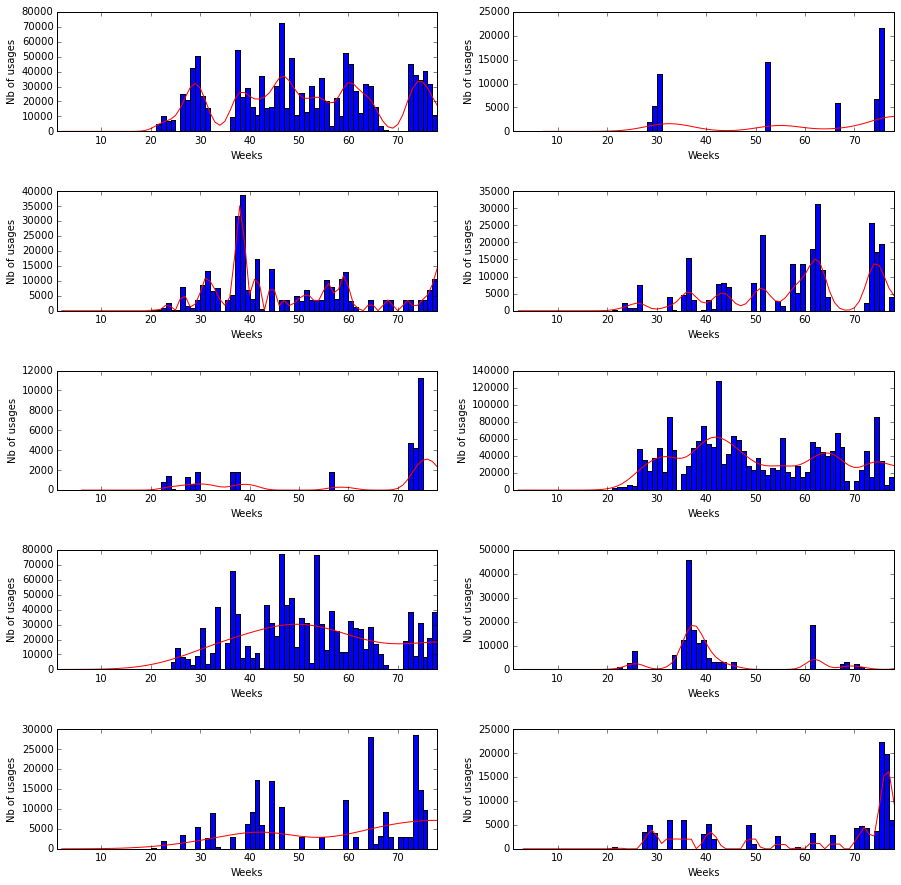

In [10]:
periods_str = [str(i) for i in range(1, 105)]
periods = [i for i in range(1, 105)]

plt.figure(figsize=(15,15))
plt.subplots_adjust( hspace=.5)
for i in range(60,70):#менять тут
    original_time_serie = data[periods_str].irow(i).values
    forecast_time_serie = forecast_data[periods_str].irow(i).values
    plt.subplot(5,2,i-59)#и тут
    plt.bar(periods, original_time_serie, width=1, bottom=0)
    plt.plot(periods, forecast_time_serie)
    plt.xlim(1,78)
    plt.xlabel('Weeks')
    plt.ylabel('Nb of usages')
plt.show()